In [1]:
import os
import numpy as np
# import efficientnet.tfkeras

from vit_keras import vit, utils
from tensorflow.keras.models import load_model
# validation
import pandas as pd

2023-03-16 16:49:33.322733: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 16:49:33.413857: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-16 16:49:33.815983: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/kannika/miniconda3/envs/vit-tf/lib/
2023-03-16 16:49:33.816031: W tensorflow/com

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


## load model

> *500 Epoch*

In [4]:
#load model  #ValueError: Unknown layer: 'Custom>ClassToken'
from tensorflow.keras.models import load_model

model_dir = '/media/SSD/rheology2023/VitModel/Regression/tensorflow_server30/Exp-1/R1/models/modelRegress_ViT_l32_Rheology_R1.h5'
model = load_model(model_dir)
height = width = model.input_shape[1]
# # model = tf.keras.models.load_model(
# #     model_dir,
# #     custom_objects={'Custom>ClassToken':tf.keras.models.Model, 'Custom>AddPositionEmbs':tf.keras.models.Model})
# # model.summary()
print(f"height: {height}, width: {width}")

2023-03-16 16:50:01.369561: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 16:50:01.833675: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8034 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


height: 224, width: 224


In [5]:
model.summary()

Model: "visionregress_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-l32 (Functional)        (None, 1024)              305510400 
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 64)  

## Evaluation model

In [6]:
###** Test set

dataframe = pd.read_csv('/home/kannika/codes_AI/Rheology2023/MSDT_datatest.csv')
print(dataframe.shape)
dataframe.head(5)

(870, 8)


,Unnamed: 0,GLY,folderName,fileName,pathimg,idt,MSDT,subset
0,0,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,158,5.63,test
1,1,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,25,0.84,test
2,2,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,7,0.25,test
3,3,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,125,4.45,test
4,4,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,19,0.63,test


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 16
valid_datagen = ImageDataGenerator(rescale=1./255)

val_generator = valid_datagen.flow_from_dataframe(
                dataframe = dataframe,
                directory = None,
                x_col = 'pathimg',
                y_col = 'MSDT',
                target_size = (height, width),
                batch_size=BATCH_SIZE,
                color_mode= 'rgb',
                class_mode='raw')

Found 870 validated image filenames.


In [8]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    
    return result[0]

#Predict
pred_list = list()
#prob_list = list()
img_path=dataframe['pathimg'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    pred_list.append(predict[0])
    print(predict)

2023-03-16 16:50:53.660660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-16 16:50:54.055442: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-16 16:50:54.056348: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-16 16:50:54.056358: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-16 16:50:54.057014: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-16 16:50:54.057163: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 5s 5s/step
[7.878357]
1/1 [==============================] - 0s 65ms/step
[0.5190268]
1/1 [==============================] - 0s 62ms/step
[0.26609194]
1/1 [==============================] - 0s 66ms/step
[6.268512]
1/1 [==============================] - 0s 65ms/step
[0.425142]
1/1 [==============================] - 0s 65ms/step
[2.3282564]
1/1 [==============================] - 0s 64ms/step
[22.5105]
1/1 [==============================] - 0s 66ms/step
[33.620117]
1/1 [==============================] - 0s 69ms/step
[61.83906]
1/1 [==============================] - 0s 66ms/step
[0.14934109]
1/1 [==============================] - 0s 66ms/step
[24.023886]
1/1 [==============================] - 0s 70ms/step
[1.4724778]
1/1 [==============================] - 0s 73ms/step
[13.964725]
1/1 [==============================] - 0s 72ms/step
[0.46746996]
1/1 [==============================] - 0s 67ms/step
[0.6728526]
1/1 [==============================] - 0s 67m

1/1 [==============================] - 0s 62ms/step
[0.3503001]
1/1 [==============================] - 0s 66ms/step
[11.546949]
1/1 [==============================] - 0s 66ms/step
[0.7653]
1/1 [==============================] - 0s 68ms/step
[7.34922]
1/1 [==============================] - 0s 65ms/step
[0.31237805]
1/1 [==============================] - 0s 60ms/step
[17.372303]
1/1 [==============================] - 0s 62ms/step
[4.9950533]
1/1 [==============================] - 0s 66ms/step
[18.666424]
1/1 [==============================] - 0s 69ms/step
[1.0355035]
1/1 [==============================] - 0s 71ms/step
[0.47236142]
1/1 [==============================] - 0s 66ms/step
[0.4593607]
1/1 [==============================] - 0s 66ms/step
[36.276978]
1/1 [==============================] - 0s 67ms/step
[0.17424843]
1/1 [==============================] - 0s 60ms/step
[0.42008087]
1/1 [==============================] - 0s 61ms/step
[0.13765821]
1/1 [==============================] - 0

1/1 [==============================] - 0s 66ms/step
[1.1750088]
1/1 [==============================] - 0s 70ms/step
[8.645303]
1/1 [==============================] - 0s 69ms/step
[14.587036]
1/1 [==============================] - 0s 67ms/step
[0.09428737]
1/1 [==============================] - 0s 68ms/step
[0.6529066]
1/1 [==============================] - 0s 71ms/step
[0.95917726]
1/1 [==============================] - 0s 65ms/step
[4.4184384]
1/1 [==============================] - 0s 68ms/step
[0.32291043]
1/1 [==============================] - 0s 71ms/step
[2.1766298]
1/1 [==============================] - 0s 67ms/step
[0.6364293]
1/1 [==============================] - 0s 70ms/step
[0.21911553]
1/1 [==============================] - 0s 65ms/step
[44.335205]
1/1 [==============================] - 0s 67ms/step
[0.63787335]
1/1 [==============================] - 0s 70ms/step
[22.963932]
1/1 [==============================] - 0s 70ms/step
[0.9903462]
1/1 [==============================]

[9.81714]
1/1 [==============================] - 0s 70ms/step
[17.277197]
1/1 [==============================] - 0s 69ms/step
[7.3759418]
1/1 [==============================] - 0s 69ms/step
[0.3527601]
1/1 [==============================] - 0s 67ms/step
[15.880843]
1/1 [==============================] - 0s 71ms/step
[0.21112312]
1/1 [==============================] - 0s 68ms/step
[0.14694539]
1/1 [==============================] - 0s 71ms/step
[25.522099]
1/1 [==============================] - 0s 66ms/step
[10.440667]
1/1 [==============================] - 0s 64ms/step
[0.245249]
1/1 [==============================] - 0s 64ms/step
[0.3320123]
1/1 [==============================] - 0s 65ms/step
[0.13696168]
1/1 [==============================] - 0s 64ms/step
[0.81635875]
1/1 [==============================] - 0s 72ms/step
[0.23784189]
1/1 [==============================] - 0s 65ms/step
[20.401722]
1/1 [==============================] - 0s 63ms/step
[0.38959658]
1/1 [====================

1/1 [==============================] - 0s 65ms/step
[2.4188414]
1/1 [==============================] - 0s 72ms/step
[0.19722998]
1/1 [==============================] - 0s 67ms/step
[0.3533865]
1/1 [==============================] - 0s 64ms/step
[0.2545252]
1/1 [==============================] - 0s 67ms/step
[2.3758996]
1/1 [==============================] - 0s 66ms/step
[11.7643585]
1/1 [==============================] - 0s 69ms/step
[4.05699]
1/1 [==============================] - 0s 63ms/step
[0.6737367]
1/1 [==============================] - 0s 65ms/step
[0.34718466]
1/1 [==============================] - 0s 64ms/step
[1.0962042]
1/1 [==============================] - 0s 63ms/step
[16.585154]
1/1 [==============================] - 0s 67ms/step
[0.3158212]
1/1 [==============================] - 0s 67ms/step
[0.55681396]
1/1 [==============================] - 0s 67ms/step
[0.19597143]
1/1 [==============================] - 0s 67ms/step
[1.3512874]
1/1 [==============================] 

1/1 [==============================] - 0s 68ms/step
[0.4796613]
1/1 [==============================] - 0s 69ms/step
[1.2898147]
1/1 [==============================] - 0s 67ms/step
[0.08390574]
1/1 [==============================] - 0s 64ms/step
[0.26014405]
1/1 [==============================] - 0s 64ms/step
[0.1239357]
1/1 [==============================] - 0s 66ms/step
[0.10316896]
1/1 [==============================] - 0s 74ms/step
[0.06411909]
1/1 [==============================] - 0s 65ms/step
[0.2587775]
1/1 [==============================] - 0s 68ms/step
[0.1998732]
1/1 [==============================] - 0s 64ms/step
[0.5496813]
1/1 [==============================] - 0s 62ms/step
[0.22687542]
1/1 [==============================] - 0s 64ms/step
[2.0502262]
1/1 [==============================] - 0s 70ms/step
[1.7828363]
1/1 [==============================] - 0s 66ms/step
[7.1064334]
1/1 [==============================] - 0s 68ms/step
[4.0450726]
1/1 [==============================

1/1 [==============================] - 0s 68ms/step
[6.019961]
1/1 [==============================] - 0s 69ms/step
[0.08462901]
1/1 [==============================] - 0s 73ms/step
[0.43168905]
1/1 [==============================] - 0s 71ms/step
[0.23252821]
1/1 [==============================] - 0s 71ms/step
[0.12001531]
1/1 [==============================] - 0s 69ms/step
[0.40044177]
1/1 [==============================] - 0s 71ms/step
[0.21461476]
1/1 [==============================] - 0s 71ms/step
[0.42920384]
1/1 [==============================] - 0s 70ms/step
[0.10578589]
1/1 [==============================] - 0s 73ms/step
[0.14339992]
1/1 [==============================] - 0s 71ms/step
[4.001274]
1/1 [==============================] - 0s 70ms/step
[0.0811373]
1/1 [==============================] - 0s 64ms/step
[0.07302341]
1/1 [==============================] - 0s 69ms/step
[0.02110549]
1/1 [==============================] - 0s 72ms/step
[0.19963016]
1/1 [=========================

In [11]:
pred_list

[8.262802,
 0.75134426,
 0.29029882,
 6.7379947,
 0.40860105,
 2.5248775,
 20.715302,
 36.448376,
 61.408447,
 0.26398996,
 22.817202,
 3.013108,
 12.737481,
 0.38015273,
 1.0791153,
 0.24668881,
 34.720512,
 0.17179762,
 0.2910313,
 43.621014,
 13.47375,
 18.652023,
 0.60424894,
 0.3653159,
 29.009974,
 1.7009809,
 1.3347067,
 5.5605803,
 0.27611455,
 17.438286,
 38.900066,
 2.7733243,
 2.0369568,
 0.11429395,
 0.14780703,
 14.488411,
 13.048964,
 6.3142467,
 40.125805,
 0.3233272,
 0.19451952,
 25.987988,
 2.512475,
 0.0045992658,
 0.23366357,
 10.1288185,
 0.7027934,
 0.17477137,
 48.995876,
 28.320827,
 0.1337179,
 60.502136,
 2.8055086,
 0.15282746,
 0.5401516,
 0.24242176,
 7.396653,
 0.057621647,
 0.33388296,
 0.76555675,
 5.740838,
 12.430748,
 40.381382,
 0.26399213,
 32.039368,
 0.19830976,
 0.2577176,
 0.52239037,
 4.78552,
 2.441036,
 0.337597,
 33.293568,
 0.24503762,
 15.568778,
 0.7207197,
 5.71532,
 0.3248926,
 1.4612671,
 57.366154,
 27.011713,
 0.19054414,
 5.37483,
 

In [9]:
print(len(pred_list))

dataframe['pre_MSDT'] = pred_list
dataframe.head(3)

870


,Unnamed: 0,GLY,folderName,fileName,pathimg,idt,MSDT,subset,pre_MSDT
0,0,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,158,5.63,test,7.878357
1,1,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,25,0.84,test,0.519027
2,2,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,7,0.25,test,0.266092


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


y_test = dataframe['MSDT'].tolist()
# The mean squared error
print("Root Mean squared error: %.4f" % mean_squared_error(y_test, pred_list, squared=False))
print("Mean squared error: %.4f" % mean_squared_error(y_test, pred_list))
print("Mean absolute error: %.4f" % mean_absolute_error(y_test, pred_list))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_test, pred_list))

Root Mean squared error: 2.0230
Mean squared error: 4.0926
Mean absolute error: 1.1104
Coefficient of determination: 0.9476


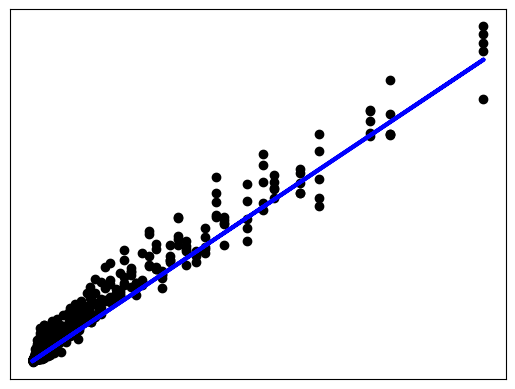

In [11]:
# Plot outputs
plt.scatter(y_test, pred_list, color="black")
plt.plot(y_test, y_test, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

## Plot : GLY10

> ## t & msd unit

In [12]:
import random

## Set solution
G = 10
_G = f"GLY{G}"

df_idt = pd.read_csv(f'/home/kannika/codes_AI/Rheology2023/MSDT_G{G}.csv')
print(df_idt.shape)
_GLY = dataframe[dataframe['GLY']==_G]
setFolder = list(set(_GLY['folderName']))
rand = random.choices(setFolder, k=1)
rand_ = rand[0]
df_rand = _GLY[_GLY['folderName']==rand_].reset_index(drop=True)
print(df_rand.shape)
df_rand = df_rand.sort_values(by=['idt'])
list_t = df_idt['t'].tolist()
df_rand['t'] = list_t
df_rand.head(3)

(29, 3)
(29, 9)


,Unnamed: 0,GLY,folderName,fileName,pathimg,idt,MSDT,subset,pre_MSDT,t
22,80,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_204812,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_204812...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,1,0.05,test,0.040782,0.052498
7,65,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_204812,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_204812...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,2,0.09,test,0.098981,0.091199
14,72,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_204812,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_204812...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,3,0.14,test,0.148738,0.140551


In [36]:
#df_rand['idt'].tolist()

In [13]:
#df_idt['dt'].tolist()
lstMSDT = df_rand['MSDT'].tolist() 
lstpre_MSDT = df_rand['pre_MSDT'].tolist() 
print(len(lstMSDT))
print(len(lstpre_MSDT))

29
29


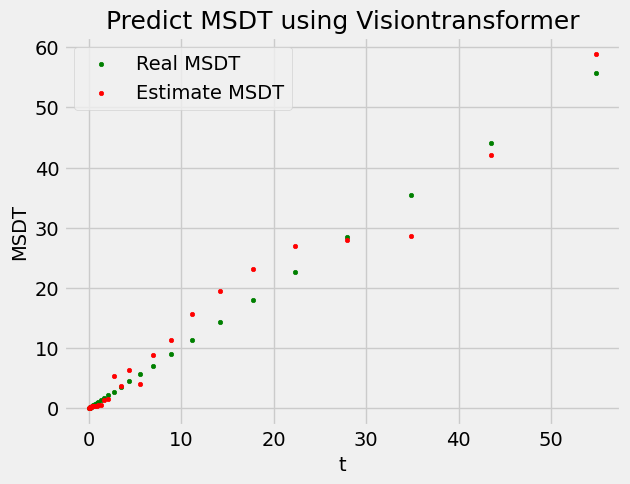

In [14]:
import matplotlib.pyplot as plt
## setting plot style
plt.style.use('fivethirtyeight')
  
## plotting residual errors in training data
plt.scatter(list_t, lstMSDT,
            color = "green", s = 10, label = 'Real MSDT')
## plotting residual errors in test data
plt.scatter(list_t, lstpre_MSDT,
            color = "red", s = 10, label = 'Estimate MSDT')
## plotting line for zero residual error
#plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
## plotting legend
plt.legend(loc = 'upper left')
## plot title
plt.title("Predict MSDT using Visiontransformer", size=18)
plt.xlabel("t", size=14)
plt.ylabel("MSDT", size=14)
## method call for showing the plot
plt.show()

In [15]:
print(min(list_t))
print(max(list_t))

0.052498082
54.81658222


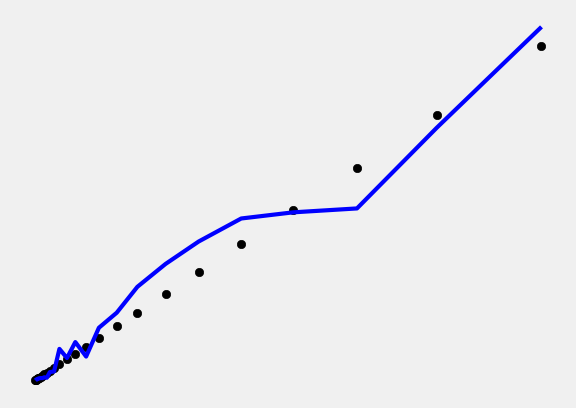

In [16]:
# Plot outputs
plt.scatter(list_t, lstMSDT, color="black")
plt.plot(list_t, lstpre_MSDT, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

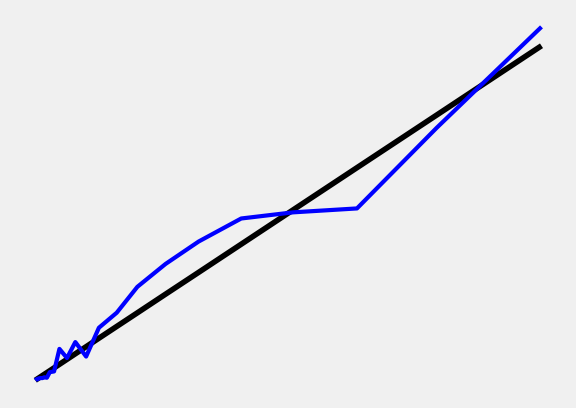

In [17]:
# Plot outputs
plt.plot(list_t, lstMSDT, color="black")
plt.plot(list_t, lstpre_MSDT, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

---------------------------------